In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

# Configuration
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 2
CLASS_NAMES = ['CBD', 'fungal']
BASE_PATH = 'dataset'
MODEL_PATH = 'models/disease_detection_model.h5'
TF_LITE_MODEL_PATH = 'models/disease_detection_model.tflite'
TF_LITE_QUANTIZED_PATH = 'models/disease_detection_model_quantized.tflite'

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

In [ ]:

def preprocess_leaf_image(image, show_steps=False):
    """Enhanced preprocessing with clear disease spot visualization"""
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # 1. Resize with aspect ratio preservation
    h, w = image.shape[:2]
    scale = min(INPUT_SHAPE[0]/h, INPUT_SHAPE[1]/w)
    new_h, new_w = int(h*scale), int(w*scale)
    resized = cv2.resize(image, (new_w, new_h))
    
    # Pad to target size
    pad_h = (INPUT_SHAPE[0] - new_h) // 2
    pad_w = (INPUT_SHAPE[1] - new_w) // 2
    padded = cv2.copyMakeBorder(resized, 
                              pad_h, INPUT_SHAPE[0]-new_h-pad_h,
                              pad_w, INPUT_SHAPE[1]-new_w-pad_w,
                              cv2.BORDER_CONSTANT, 
                              value=[0,0,0])
    
    # 2. Convert to LAB color space
    lab = cv2.cvtColor(padded, cv2.COLOR_RGB2LAB)
    l_channel = lab[:,:,0]
    
    # 3. Create masks (using inverse thresholding for processing)
    _, leaf_mask = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, disease_spots = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE)
    
    # Create visualization version (non-inverted for display)
    disease_spots_visual = cv2.bitwise_not(disease_spots)  # Inverted for clear visualization
    
    # 4. Combine masks
    combined_mask = cv2.bitwise_or(leaf_mask, disease_spots)
    
    # 5. Refine mask
    kernel = np.ones((3,3), np.uint8)
    clean_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # 6. Find largest contour
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(clean_mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(final_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    # 7. Apply mask to LAB image
    masked_lab = cv2.bitwise_and(lab, lab, mask=final_mask)
    
    # 8. Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    masked_lab[:,:,0] = clahe.apply(masked_lab[:,:,0])
    enhanced = cv2.cvtColor(masked_lab, cv2.COLOR_LAB2RGB)
    final = enhanced.astype(np.float32) / 255.0
    
    if show_steps:
        plt.figure(figsize=(15, 10))
        steps = [
            ("1. Original", padded),
            ("2. LAB Color Space", lab),
            ("3. L Channel", l_channel),
            ("5. Combined Mask", combined_mask),
            ("6. Final Mask", final_mask),
            ("7. Masked LAB", masked_lab),
            ("8. Final Enhanced", final)
        ]
        for i, (title, img) in enumerate(steps, 1):
            plt.subplot(2, 4, i)
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return final


Visualizing CBD/IMG_20240727_150820.jpg with disease spot preservation


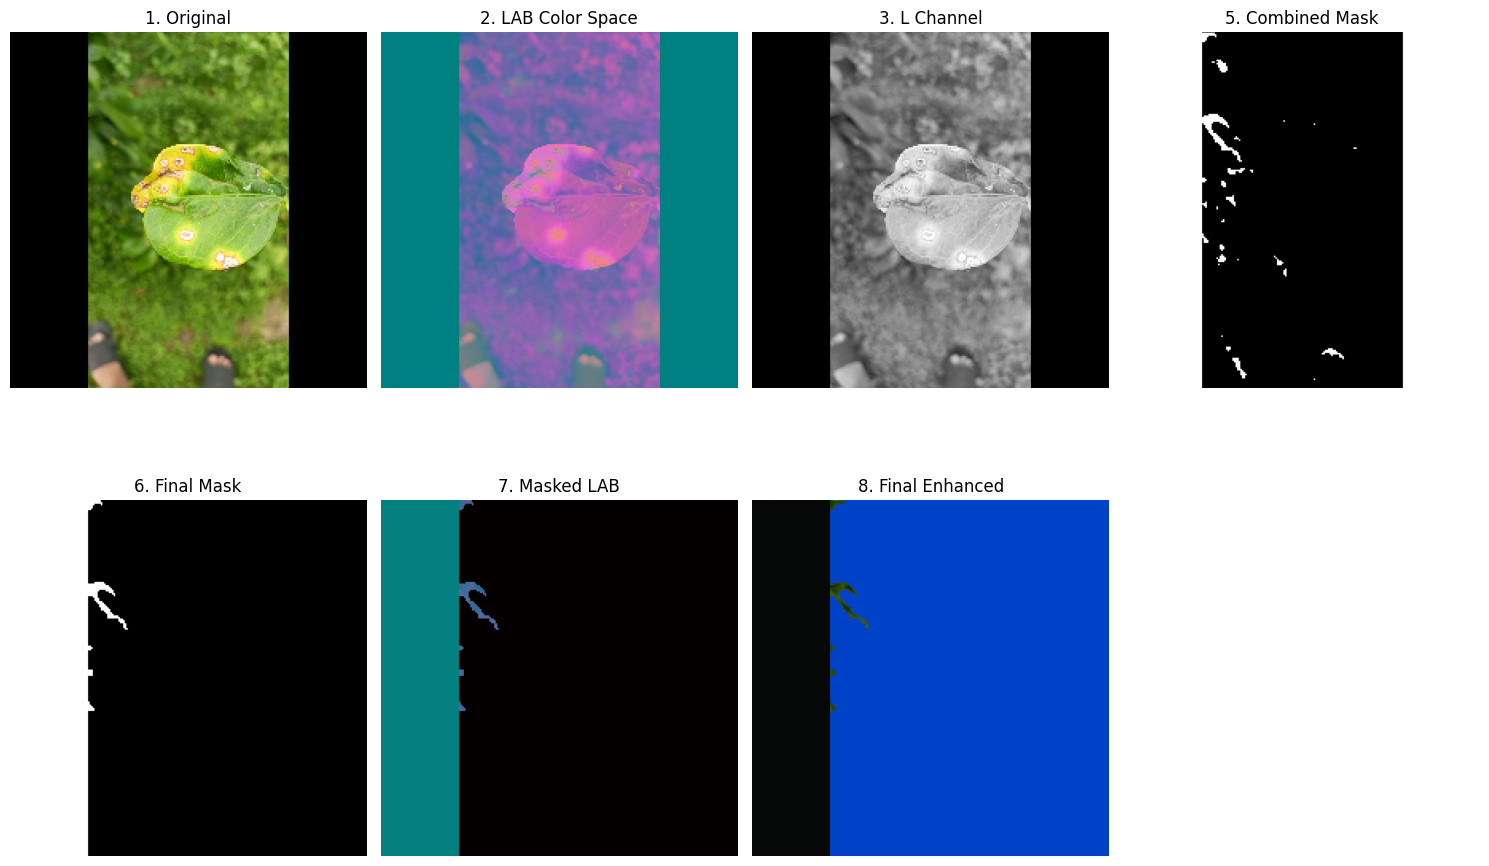


Visualizing fungal/IMG_20240823_161349.jpg with disease spot preservation


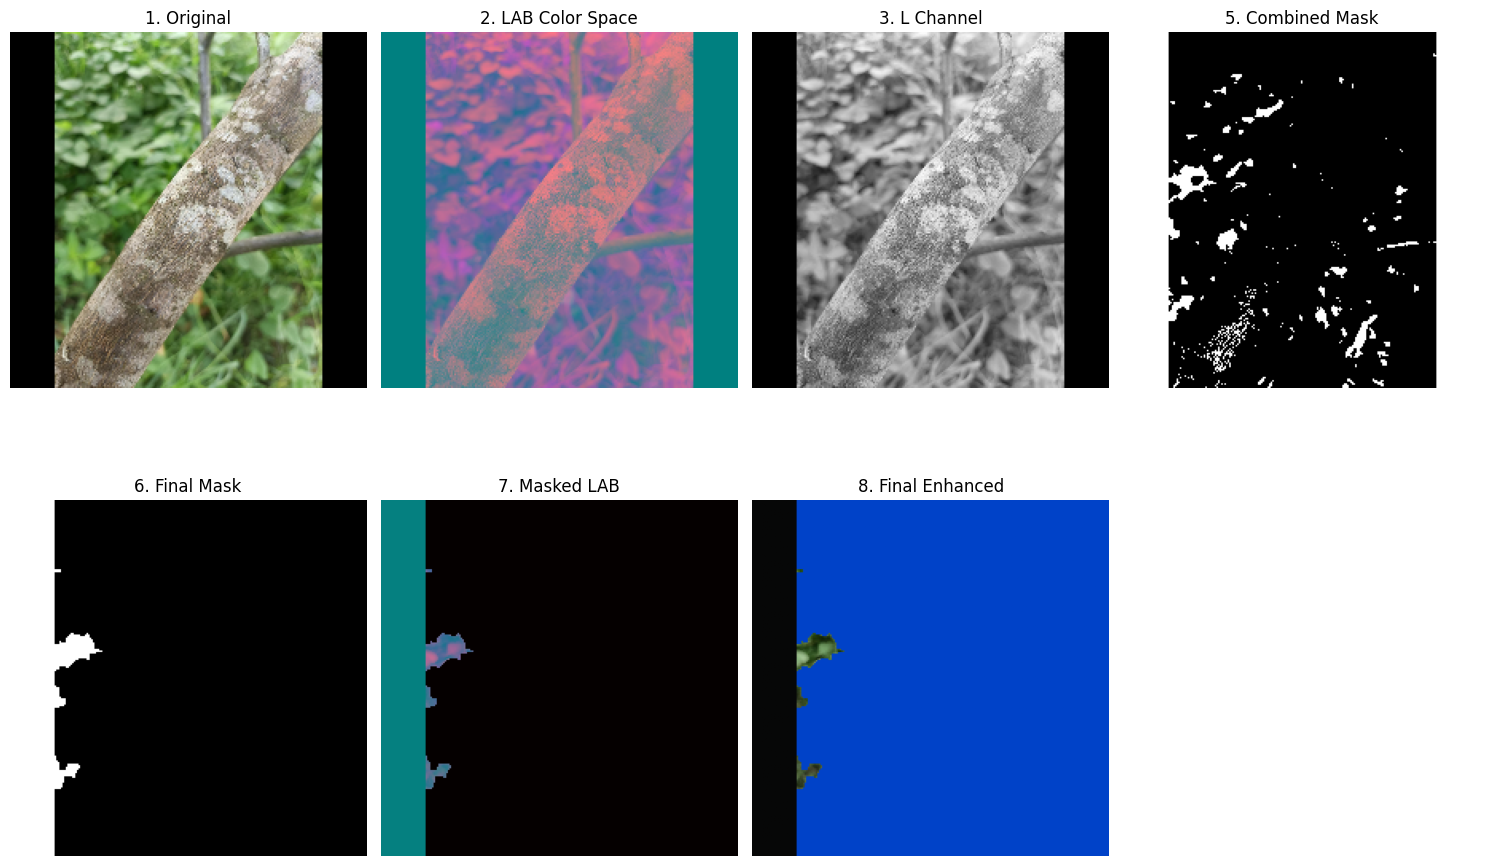

In [8]:
def visualize_sample_from_each_class():
    """Visualize one sample per class with disease spot preprocessing"""
    for selected_class in CLASS_NAMES:
        class_path = os.path.join(BASE_PATH, selected_class)
        sample_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, sample_image)

        print(f"\nVisualizing {selected_class}/{sample_image} with disease spot preservation")

        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Couldn't load {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        preprocess_leaf_image(img, show_steps=True)

visualize_sample_from_each_class()
